# Exploring unimodal data

In this tutorial, we demonstrate how to explore RNA-seq using Ocelli on two datasets. RNA-seq is the most popular single-cell modality, and here we present a new approach for its analysis.

## Pancreatic endocrinogenesis

Dataset consists of pancreatic epithelial and Ngn3-Venus fusion (NVF) cells during the secondary transition with transcriptome profiles sampled from embryonic day 15.5. Endocrine cells are derived from endocrine progenitors and form four significant lineages:

- Glucagon-producing Alpha cells,
- Insulin-producing Beta cells,
- Somatostatin-producing Delta cells,
- Ghrelin-producing Epsilon cells.

Data comes from [Bastidas-Ponce, Aimée, et al. "Comprehensive single cell mRNA profiling reveals a detailed roadmap for pancreatic endocrinogenesis." Development 146.12 (2019): dev173849.](https://journals.biologists.com/dev/article/146/12/dev173849/19483/Comprehensive-single-cell-mRNA-profiling-reveals-a). It can be easily downloaded from [scVelo](https://scvelo.readthedocs.io/scvelo.datasets.pancreas/).

Import necessary packages.

In [17]:
import ocelli as oci
import scanpy as sc
import scvelo as scv

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

SEED = 17

### Load and preprocess the data

Load the data using scVelo.

In [2]:
adata = scv.datasets.pancreas()

adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

Filter out low-expressed cells and genes.

In [3]:
sc.pp.filter_cells(adata, min_genes=20)
scv.pp.filter_genes(adata, min_shared_cells=20)

Filtered out 22533 genes that are detected in less than 20 cells (shared).


You would now calculate LDA topics in previous tutorials with multimodal data and proceed to Multimodal Diffusion Maps analysis. However, this would transpose into normal, unimodal Diffusion Maps. While such an approach is perfectly valid, LDA provides additional information - variational parameters for topic-gene distribution. These parameters can be interpreted as a pseudo count representing the number of times a gene was assigned to a topic. After running ``oci.pp.LDA``, these parameters are saved as an array of shape ``(n_var, n_topics)`` to ``adata.varm['lda']``.

Topic modeling learns cohesive groups of genes. We propose to treat them as individual modalities. ``oci.pp.modality_generation`` looks at parameters in ``adata.varm['lda']`` and assigns each gene to a highest-parameter topic. Grouped genes form new modalities (you can control how many genes at most can be in a modality - 100 is the default value). If you set ``norm_log`` to True, new modalities are normalized and logarithmized. At that point, they are ready for Multimodal Diffusion Maps training. Set multimodal weights to LDA's cell-topic probabilistic distribution. The significant advantage of such an approach is that for each region of neighboring cells, you utilize only relevant region-specific (topic-specific) genes. This step dramatically reduces noisy gene expressions. 

Let's see how it works! Train a topic model and generate new modalities.

In [4]:
oci.pp.LDA(adata, n_components=20, output_key='lda', verbose=1, max_iter=50, random_state=SEED)
oci.pp.modality_generation(adata, topic_key='lda', norm_log=True, verbose=True)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

Note that ``oci.pp.modality_generation`` automatically saves generated modality names to ``adata.uns['modalities']``.

In [5]:
adata.uns['modalities']

['modality0',
 'modality1',
 'modality2',
 'modality3',
 'modality4',
 'modality5',
 'modality6',
 'modality7',
 'modality8',
 'modality9',
 'modality10',
 'modality11',
 'modality12',
 'modality13',
 'modality14',
 'modality15',
 'modality16',
 'modality17',
 'modality18',
 'modality19']

Data downloaded from scVelo includes unspliced and spliced gene expression layers ready for RNA velocity estimation. Calculate velocities on normalized and logarithmized highly variable genes.

In [6]:
scv.pp.normalize_per_cell(adata, counts_per_cell_after=10000)
scv.pp.filter_genes_dispersion(adata, n_top_genes=1000)
scv.pp.log1p(adata)

scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Multimodal Diffusion Maps

Calculate the Multimodal Diffusion Maps representation using LDA cell-topic distributions as weights.

In [7]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.MDM(adata, weights_key='lda', n_components=25, random_state=SEED, verbose=True)

[modality0] 20 nearest neighbors calculated.
[modality1] 20 nearest neighbors calculated.
[modality2] 20 nearest neighbors calculated.
[modality3] 20 nearest neighbors calculated.
[modality4] 20 nearest neighbors calculated.
[modality5] 20 nearest neighbors calculated.
[modality6] 20 nearest neighbors calculated.
[modality7] 20 nearest neighbors calculated.
[modality8] 20 nearest neighbors calculated.
[modality9] 20 nearest neighbors calculated.
[modality10] 20 nearest neighbors calculated.
[modality11] 20 nearest neighbors calculated.
[modality12] 20 nearest neighbors calculated.
[modality13] 20 nearest neighbors calculated.
[modality14] 20 nearest neighbors calculated.
[modality15] 20 nearest neighbors calculated.
[modality16] 20 nearest neighbors calculated.
[modality17] 20 nearest neighbors calculated.
[modality18] 20 nearest neighbors calculated.
[modality19] 20 nearest neighbors calculated.


2022-10-16 14:00:23,339	INFO worker.py:1518 -- Started a local Ray instance.


[modality0] Unimodal Markov chain calculated
[modality1] Unimodal Markov chain calculated
[modality2] Unimodal Markov chain calculated
[modality3] Unimodal Markov chain calculated
[modality4] Unimodal Markov chain calculated
[modality5] Unimodal Markov chain calculated
[modality6] Unimodal Markov chain calculated
[modality7] Unimodal Markov chain calculated
[modality8] Unimodal Markov chain calculated
[modality9] Unimodal Markov chain calculated
[modality10] Unimodal Markov chain calculated
[modality11] Unimodal Markov chain calculated
[modality12] Unimodal Markov chain calculated
[modality13] Unimodal Markov chain calculated
[modality14] Unimodal Markov chain calculated
[modality15] Unimodal Markov chain calculated
[modality16] Unimodal Markov chain calculated
[modality17] Unimodal Markov chain calculated
[modality18] Unimodal Markov chain calculated
[modality19] Unimodal Markov chain calculated
Multimodal Markov chain calculated
Eigendecomposition finished.
25 Multimodal Diffusion Ma

Calculate force-directed layout 2D representation.

[X_mdm] 100 nearest neighbors calculated.
RNA velocity-based graph constructed.


Oct 16, 2022 2:02:46 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Oct 16, 2022 2:02:47 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 3,696 (3,696 added)
Oct 16, 2022 2:02:47 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 73,920 (70,765 added)


*************************25%
*************************50%
*************************75%
*************************100%
Time = 23.573s


(<Figure size 1920x1440 with 1 Axes>, <AxesSubplot:>)

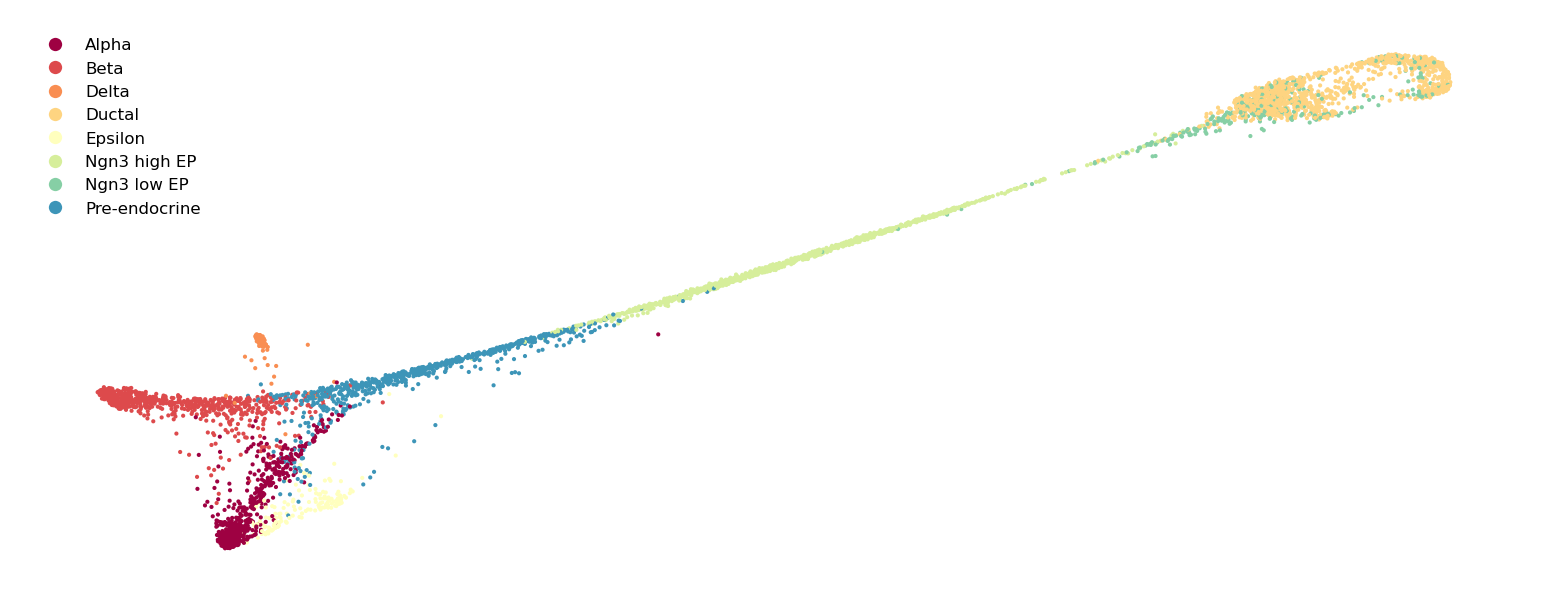

In [18]:
oci.pp.neighbors(adata, modalities=['X_mdm'], n_neighbors=100, verbose=True)
oci.tl.velocity_graph(adata, n_edges=20, neighbors_key='X_mdm', verbose=True)

oci.tl.FA2(adata, n_components=2, random_state=SEED, output_key='X_fa2')

oci.pl.scatter(adata, x_key='X_fa2', color_key='clusters', static=True, marker_size=1)

The power of this approach is that during the dimension reduction process, you examine simultaneously multiple genomically different regions using only region-specific genes. You can examine learned regions by plotting cell-topic distributions. Region-selected genes are saved to ``adata.uns['vars_*']``, where ``*`` denotes the name of modality.

(<Figure size 1920x1440 with 21 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>],
        [<AxesSubplot:title={'center':'5'}>,
         <AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'7'}>,
         <AxesSubplot:title={'center':'8'}>,
         <AxesSubplot:title={'center':'9'}>],
        [<AxesSubplot:title={'center':'10'}>,
         <AxesSubplot:title={'center':'11'}>,
         <AxesSubplot:title={'center':'12'}>,
         <AxesSubplot:title={'center':'13'}>,
         <AxesSubplot:title={'center':'14'}>],
        [<AxesSubplot:title={'center':'15'}>,
         <AxesSubplot:title={'center':'16'}>,
         <AxesSubplot:title={'center':'17'}>,
         <AxesSubplot:title={'center':'18'}>,
         <AxesSubplot:title={'center':'19'}>]], dtype=object))

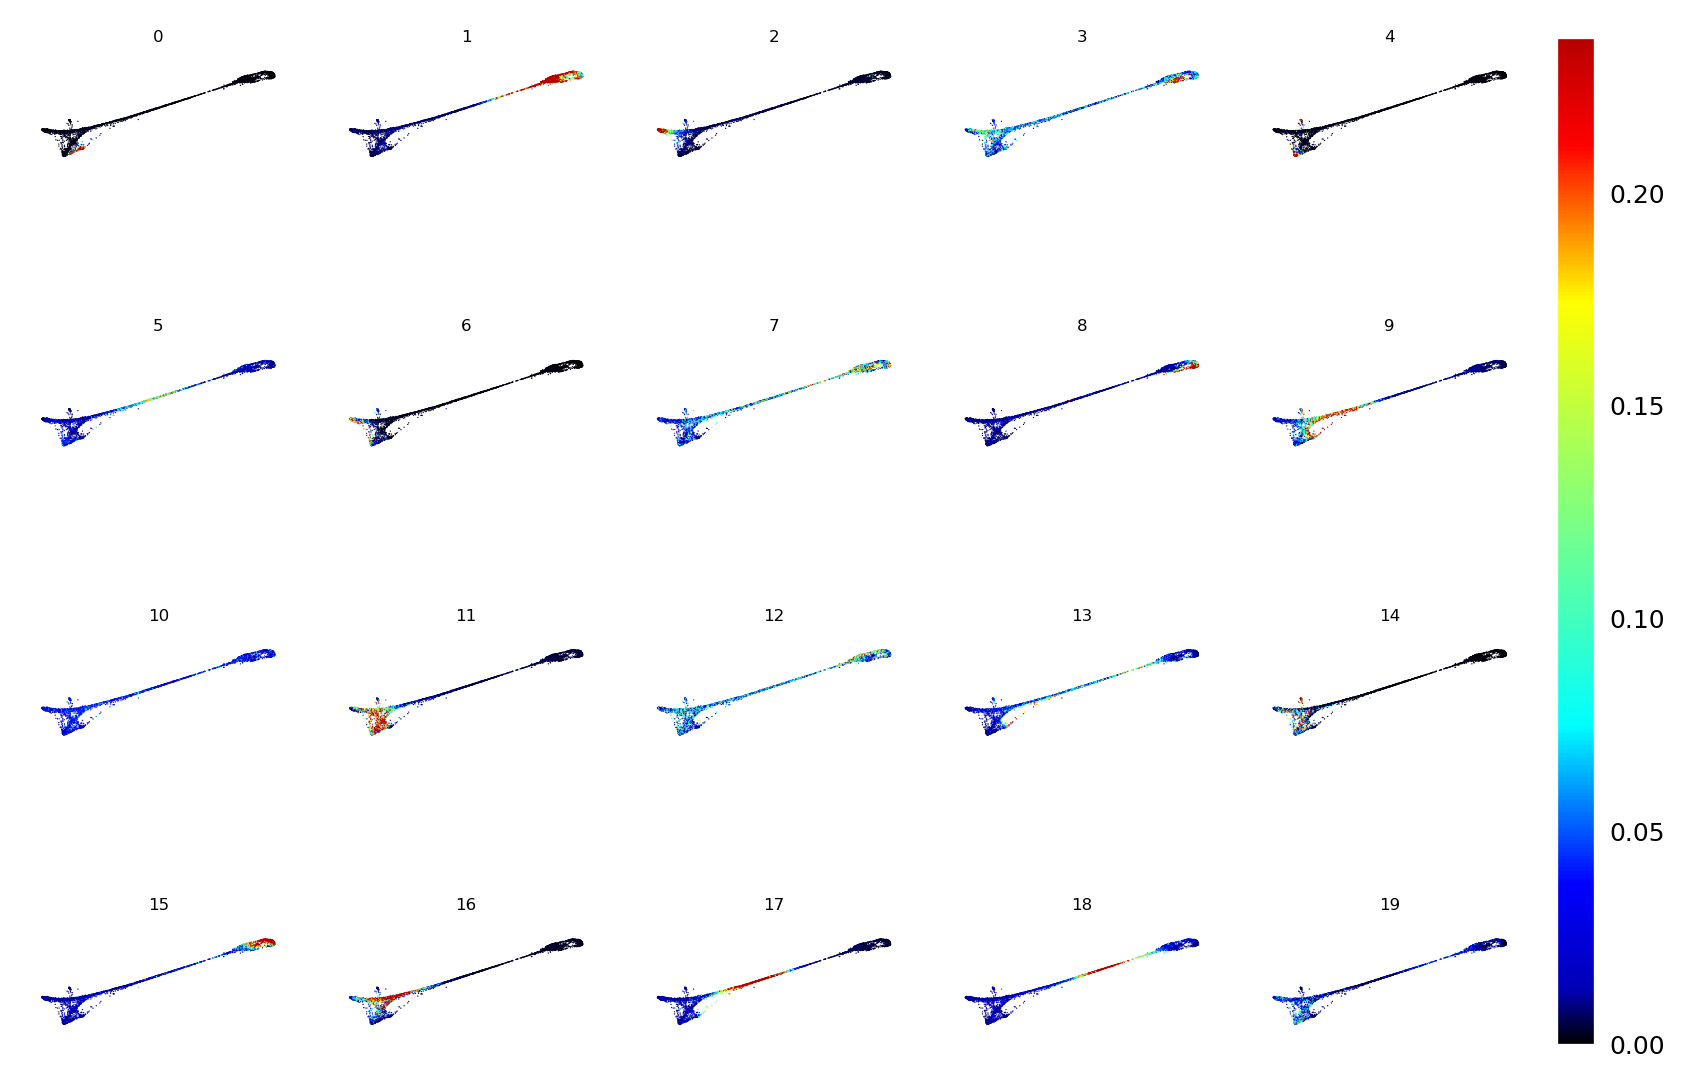

In [101]:
oci.pl.topics(adata, x_key='X_fa2', marker_size=0.1)

### Cell cycle reconstruction

There are two significant regions of interest. The first, Ductal cells, develop in a cell cycle.

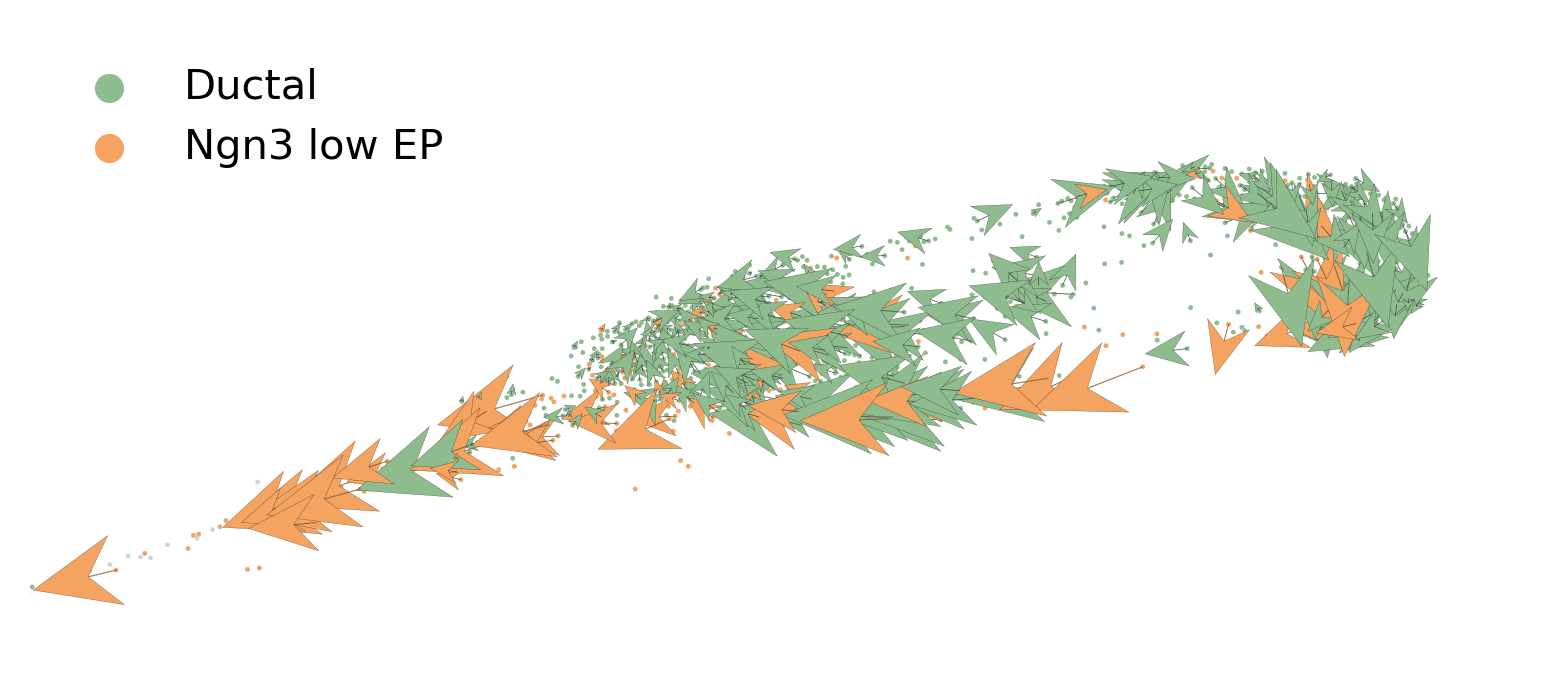

In [84]:
fig, ax = plt.subplots()
scv.pl.velocity_embedding(adata, basis='fa2', arrow_length=5, arrow_size=10, alpha=1, 
                          title='', density=0.3, size=5, legend_loc='best',
                          linewidth=0.05, show=False, ax=ax, groups=['Ductal', 'Ngn3 low EP'],
                          xlim=[8000, 14000], ylim=[2500, 5000])
ax.set_aspect('equal')

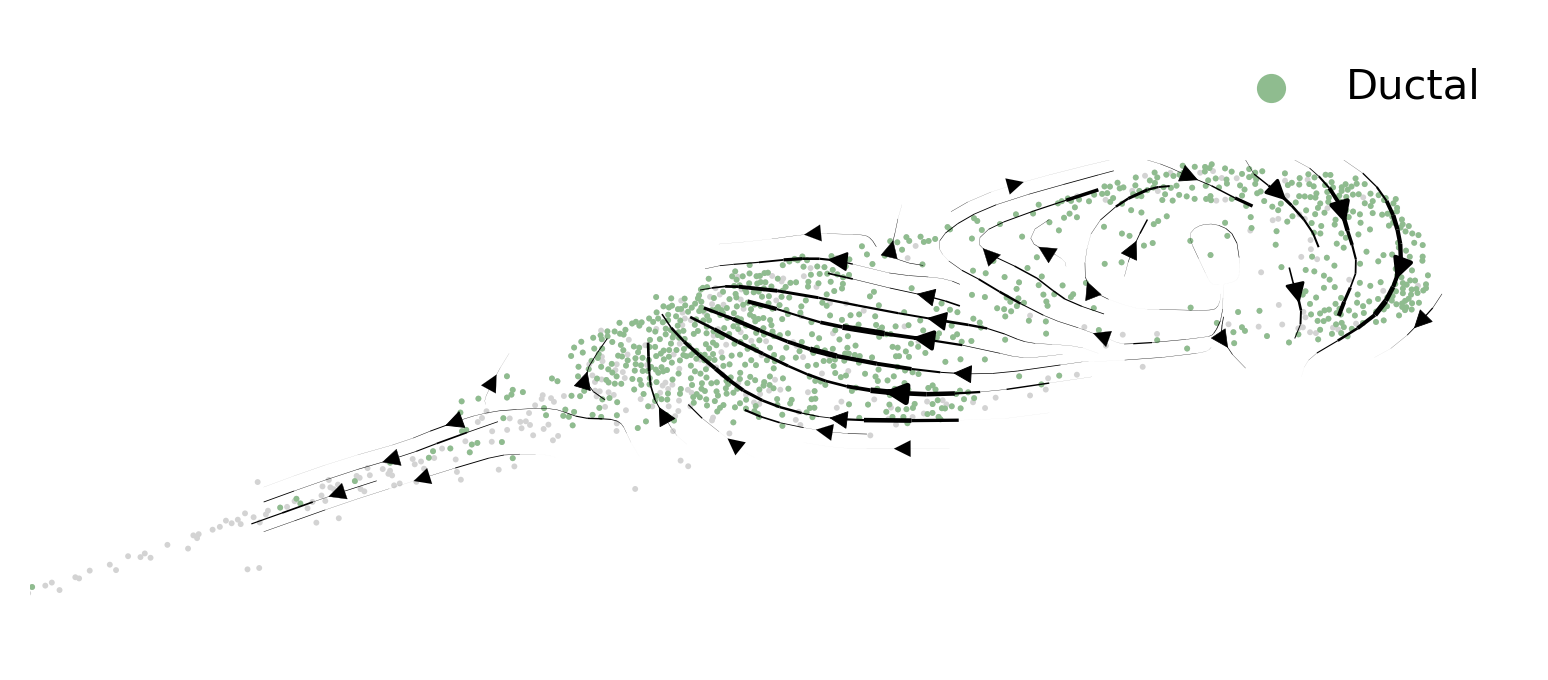

In [81]:
fig, ax = plt.subplots()

scv.pl.velocity_embedding_stream(adata, basis='fa2', alpha=1, title='', density=1, 
                                 linewidth=1, size=8, legend_loc='best', groups=['Ductal'], show=False, ax=ax, 
                                 xlim=[8000, 14000], ylim=[2500, 5000])

ax.set_aspect('equal')

We can validate the velocity stream using scores for S (DNA replication), G2 (preparation for mitosis), and M (cell division) cell cycle phases.

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


Text(0.5, 1.0, 'G2M score')

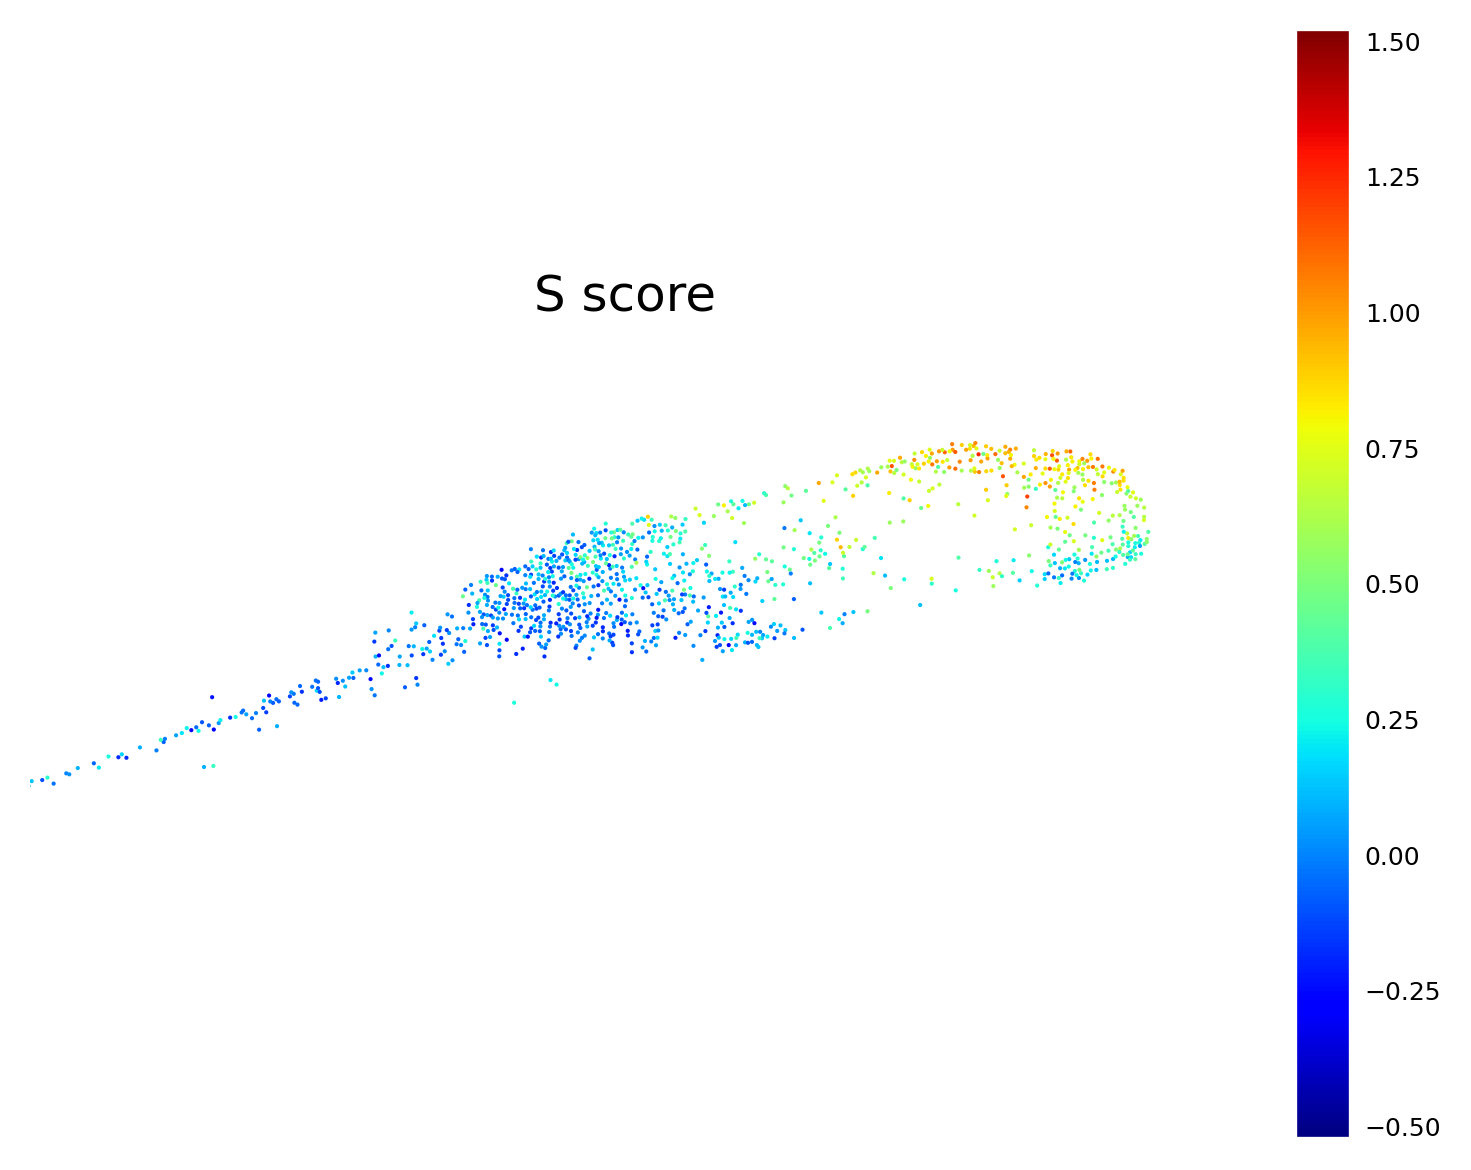

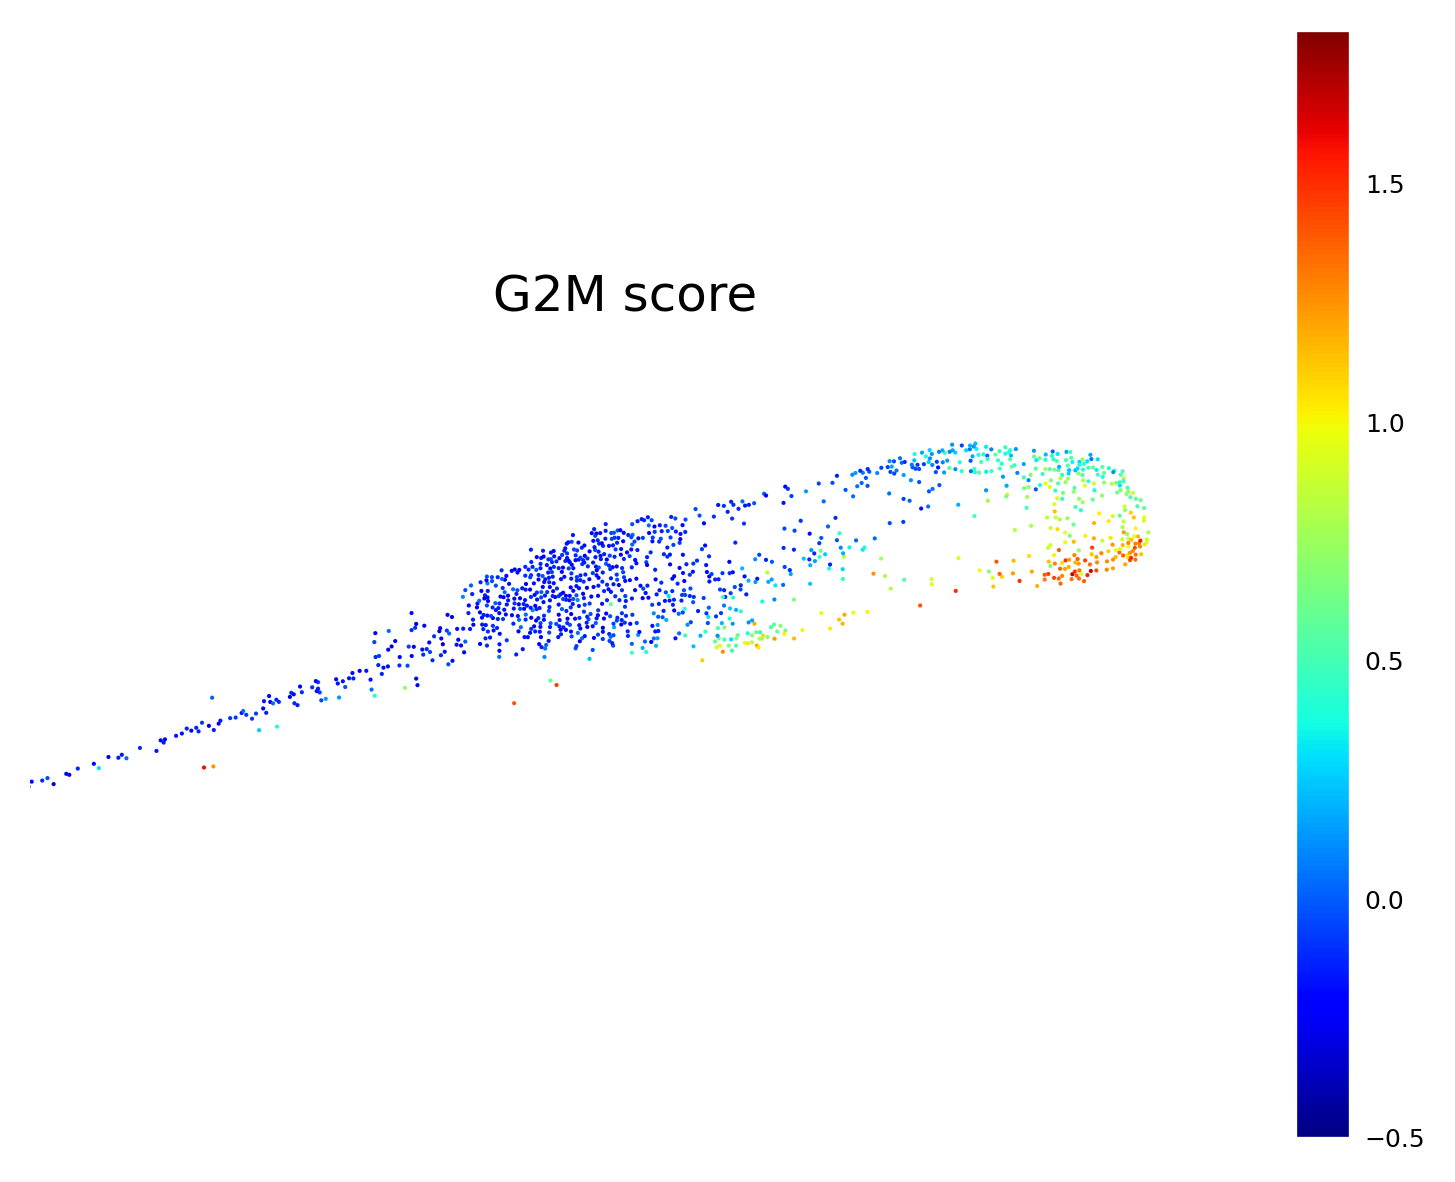

In [99]:
scv.tl.score_genes_cell_cycle(adata)
fig, ax = oci.pl.scatter(adata, x_key='X_fa2', color_key='S_score', cmap='jet', marker_size=1)
ax.set_xlim([8000, 14000])
ax.set_ylim([2500, 5000])
ax.set_title('S score')


fig, ax = oci.pl.scatter(adata, x_key='X_fa2', color_key='G2M_score', cmap='jet', marker_size=1)
ax.set_xlim([8000, 14000])
ax.set_ylim([2500, 5000])
ax.set_title('G2M score')

### Endocrine cells development

The second exciting region is the development of pre-endocrine cells to their four fates: Alpha, Beta, Delta, and Epsilon.

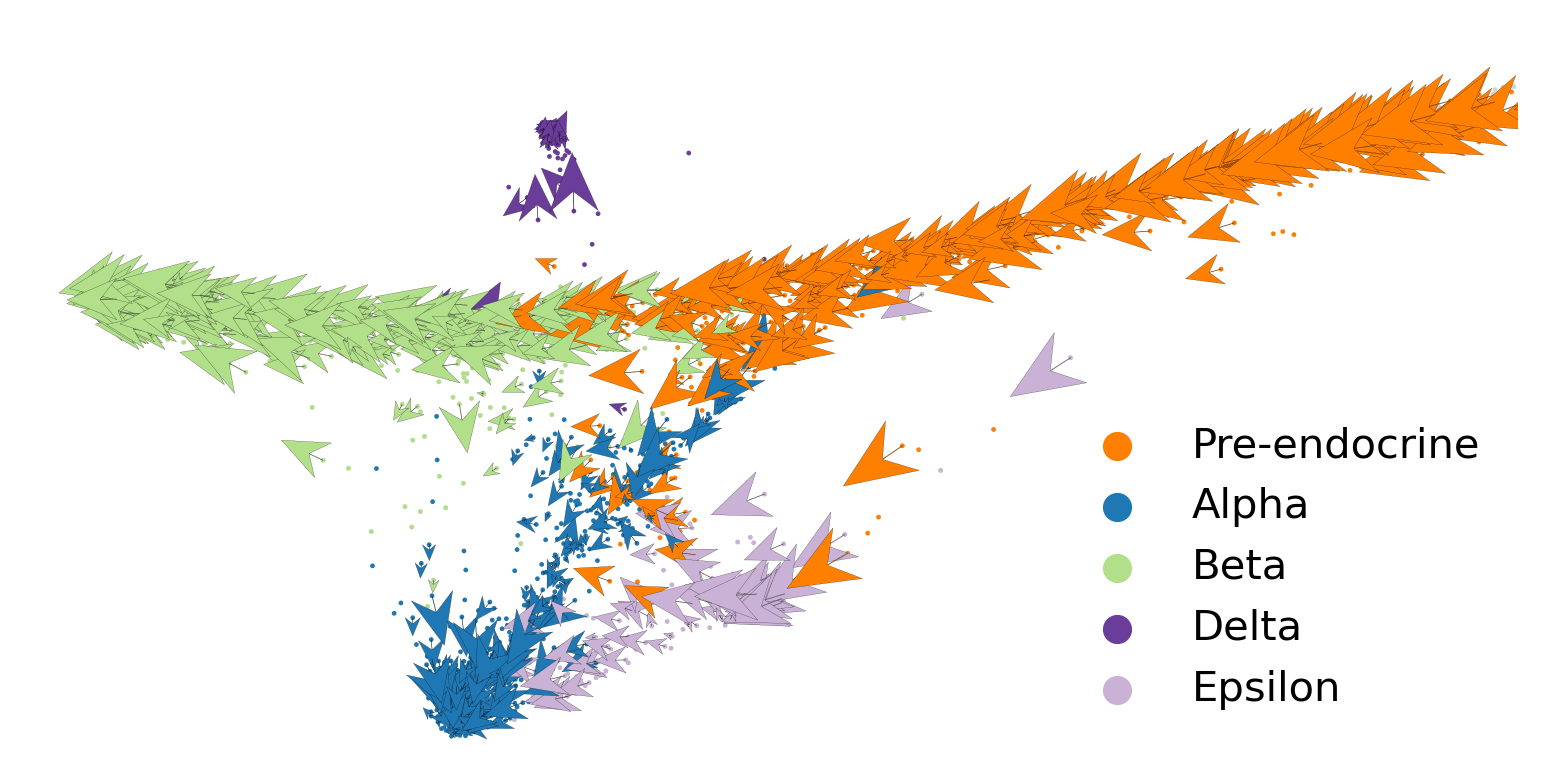

In [89]:
fig, ax = plt.subplots()
scv.pl.velocity_embedding(adata, basis='fa2', arrow_length=5, arrow_size=10, alpha=1, 
                          title='', density=0.4, size=5, legend_loc='best',
                          linewidth=0.05, show=False, ax=ax, groups=celltypes, 
                          xlim=[-8300, 0], ylim=[-3500, 500])
ax.set_aspect('equal')

## iPSCs reprogramming